In [1]:
import numpy as np
import pandas as pd

In [2]:
#import dataset from local device
df = pd.read_csv('/kaggle/input/cs-3110-mini-project/train.csv',index_col= "customer_id")
df.head()

,account_length,location_code,intertiol_plan,voice_mail_plan,number_vm_messages,total_day_min,total_day_calls,total_day_charge,total_eve_min,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,Churn,Unnamed: 20
customer_id,,,,,,,,,,,,,,,,,,,,
1001,15.0,452,no,no,0.0,121.1,130.0,20.59,216.0,86.0,18.36,235.1,33.0,10.58,16.1,5.0,4.35,2.0,No,NaN
1002,105.0,452,no,no,0.0,259.3,96.0,44.08,175.2,97.0,14.89,222.4,36.0,10.01,12.0,5.0,3.24,3.0,No,NaN
1003,97.0,452,no,yes,32.0,183.4,94.0,31.18,269.1,120.0,22.87,203.5,38.0,9.16,6.7,4.0,1.81,5.0,No,NaN
1004,121.0,445,no,yes,35.0,68.7,95.0,11.68,209.2,69.0,17.78,197.4,42.0,8.88,11.4,4.0,3.08,1.0,No,NaN
1005,98.0,452,no,yes,22.0,278.3,89.0,47.31,93.4,143.0,7.94,107.6,42.0,4.84,9.7,5.0,2.62,0.0,No,NaN


In [3]:
df.shape

(2321, 20)

In [4]:
df = df.dropna(axis=0, subset=['Churn'])

In [5]:
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]


In [6]:
Columns = df.drop(columns=['Churn']).columns

for columnName in Columns:
    if  (columnName in ['voice_mail_plan','intertiol_plan']):
        df[columnName].fillna(df[columnName].mode()[0], inplace=True)
    elif (columnName in ['account_length','number_vm_messages','total_day_calls','total_eve_calls','total_night_calls','total_intl_calls','customer_service_calls']):
        df[columnName].fillna(float(int(df[columnName].mean())), inplace=True)
    else:
        df[columnName].fillna(df[columnName].mean(), inplace=True)

In [7]:
Columns2 = df.drop(columns=['Churn','voice_mail_plan','intertiol_plan']).columns

for columnName in Columns2:
    print((df[columnName]  < 0).sum())
    df[columnName][df[columnName] < 0] = 0

0
0
1
4
1
2
1
2
0
0
0
0
3
0
0
0


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


# Feature Engineering

In [8]:
df["intertiol_plan"]= df['intertiol_plan'].map({'yes': 1, 'no': 0})
df["voice_mail_plan"]= df['voice_mail_plan'].map({'yes': 1, 'no': 0})
df["Churn"]= df['Churn'].map({'Yes': 1, 'No': 0})

In [9]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [10]:
discrete_features = df.drop(columns=["Churn"]).dtypes==int
mi_scores = make_mi_scores(df.drop(columns=["Churn"]), df.Churn, discrete_features)
mi_scores.sort_values(ascending=False)

total_night_charge        0.093646
total_day_charge          0.082801
total_day_min             0.075728
customer_service_calls    0.053585
total_eve_charge          0.047117
total_intl_charge         0.041194
total_intl_minutes        0.040839
intertiol_plan            0.031201
total_intl_calls          0.029288
number_vm_messages        0.023933
account_length            0.023431
total_eve_min             0.013523
total_day_calls           0.013115
total_night_calls         0.013099
total_eve_calls           0.012045
total_night_minutes       0.006042
voice_mail_plan           0.004134
location_code             0.003290
Name: MI Scores, dtype: float64

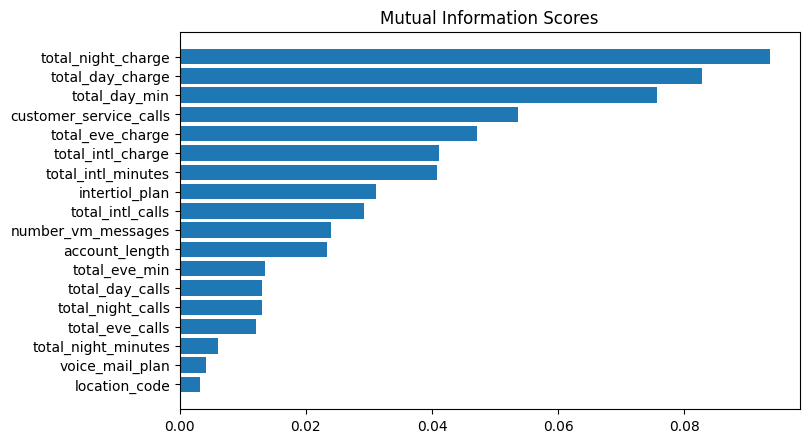

In [11]:
import matplotlib.pyplot as plt
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

In [12]:
df['total_charge'] = df['total_day_charge'] + df['total_night_charge'] + df['total_eve_charge'] + df['total_intl_charge']
# df['day_min_charge'] = df['total_day_charge'] + df['total_day_min']
df['total_min'] = df['total_day_min'] + df['total_night_minutes'] + df['total_eve_min'] + df['total_intl_minutes']
# df['total_call'] = df['total_day_calls'] + df['total_eve_calls'] + df['total_night_calls'] + df['total_intl_calls']
# df['membership']= df['intertiol_plan'] + df['voice_mail_plan']
# df['total_charge*min'] = df['total_charge'] + df['total_min'] 

In [13]:
df['total_day_calls'][df['total_day_calls'] > 200] = df['total_day_calls'].mean()
df['total_day_min'][df['total_day_min'] > 600] = df['total_day_min'].mean()


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [14]:
(df['number_vm_messages']  <= 0).sum()
df['number_vm_messages'][df['number_vm_messages']<= 0] = 1

df['number_vm_messages'] = np.log(df['number_vm_messages'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [15]:
df['total_min'].describe()

count     2316.000000
mean       606.322779
std        429.604731
min        284.300000
25%        530.350000
50%        595.750000
75%        660.250000
max      20020.800000
Name: total_min, dtype: float64

In [16]:
def monthlycharges_split(df) : 
    if df['total_charge'] <= 52.417500 :
        return 0
    elif ((df['total_charge'] > 52.417500) & (df['total_charge'] <= 67.650000) ):
        return 0
    elif df['total_charge'] > 67.650000 :
        return 2
df['totalcharges_group'] = df.apply(lambda df:monthlycharges_split(df), axis = 1)


In [17]:
df

,account_length,location_code,intertiol_plan,voice_mail_plan,number_vm_messages,total_day_min,total_day_calls,total_day_charge,total_eve_min,total_eve_calls,...,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,Churn,total_charge,total_min,totalcharges_group
customer_id,,,,,,,,,,,,,,,,,,,,,
1001,15.0,452,0,0,0.000000,121.1,130.0,20.59,216.0,86.0,...,33.0,10.58,16.1,5.0,4.35,2.0,0,53.88,588.3,0
1002,105.0,452,0,0,0.000000,259.3,96.0,44.08,175.2,97.0,...,36.0,10.01,12.0,5.0,3.24,3.0,0,72.22,668.9,2
1003,97.0,452,0,1,3.465736,183.4,94.0,31.18,269.1,120.0,...,38.0,9.16,6.7,4.0,1.81,5.0,0,65.02,662.7,0
1004,121.0,445,0,1,3.555348,68.7,95.0,11.68,209.2,69.0,...,42.0,8.88,11.4,4.0,3.08,1.0,0,41.42,486.7,0
1005,98.0,452,0,1,3.091042,278.3,89.0,47.31,93.4,143.0,...,42.0,4.84,9.7,5.0,2.62,0.0,0,62.71,489.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3317,109.0,452,0,0,0.000000,180.0,100.0,30.60,229.0,103.0,...,105.0,6.27,7.8,8.0,2.11,3.0,0,58.45,556.2,0
3318,185.0,452,1,1,3.401197,154.1,114.0,26.20,118.7,106.0,...,105.0,11.63,12.9,3.0,3.48,2.0,0,51.40,544.1,0
3319,55.0,452,1,0,0.000000,188.9,88.0,34.62,270.1,105.0,...,105.0,9.17,14.3,5.0,3.86,1.0,1,70.42,683.0,2


In [18]:
discrete_features = df.drop(columns=["Churn"]).dtypes==int
mi_scores = make_mi_scores(df.drop(columns=["Churn"]), df.Churn, discrete_features)
mi_scores.sort_values(ascending=False)

total_charge              0.143542
total_night_charge        0.084063
total_day_charge          0.080863
total_day_min             0.078001
total_min                 0.054193
totalcharges_group        0.051652
total_eve_charge          0.051196
customer_service_calls    0.046130
total_intl_charge         0.043232
account_length            0.042606
total_intl_minutes        0.031073
intertiol_plan            0.031006
number_vm_messages        0.019223
voice_mail_plan           0.018081
total_day_calls           0.016540
total_eve_min             0.009978
total_intl_calls          0.008520
location_code             0.007645
total_night_minutes       0.001460
total_eve_calls           0.000000
total_night_calls         0.000000
Name: MI Scores, dtype: float64

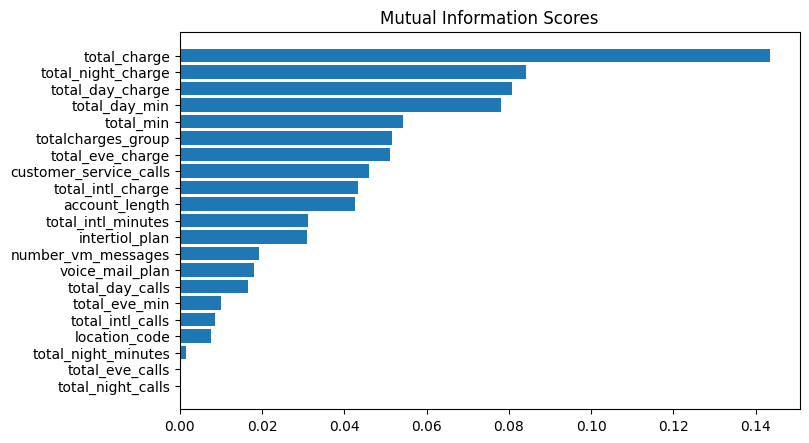

In [19]:
import matplotlib.pyplot as plt
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

# Model Selection

In [20]:
X = df.drop(columns=['Churn'])
y =df.Churn

In [21]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Initialze the estimators
clf1 = RandomForestClassifier(random_state=42)
clf2 = SVC(probability=True, random_state=42)
clf3 = KNeighborsClassifier()


# Initiaze the hyperparameters for each dictionary
# param1 = {}
# param1['classifier__n_estimators'] = [10, 50, 100, 250]
# param1['classifier__max_depth'] = [20, 30]
# param1['classifier__random_state'] = [1,3, 5, 10, 20, 30, 42, 50]
# param1['classifier__class_weight'] = [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
# param1['classifier'] = [clf1]

param2 = {}
param2['classifier__C'] = [10**-2, 10**-1, 10**0, 10**1, 10**2]
param2['classifier__class_weight'] = [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
param2['classifier'] = [clf2]

# param3 = {}
# param3['classifier__n_neighbors'] = [2,5,10,25,50]
# param3['classifier'] = [clf3]

pipeline = Pipeline([('classifier', clf1)])
params = [param2]


gs = GridSearchCV(pipeline, params, cv=5, n_jobs=-1, scoring="accuracy").fit(X, y)

In [22]:
print(gs.best_params_)
print(gs.best_score_)

{'classifier': SVC(C=100, probability=True, random_state=42), 'classifier__C': 100, 'classifier__class_weight': None}
0.8225357488642289


In [23]:
from sklearn.model_selection import cross_val_score

In [24]:
RF1 = KNeighborsClassifier()
cross_val_score(RF1, X, y, cv = 5).mean()

0.780227340433455

In [25]:
from sklearn.ensemble import RandomForestClassifier


RF = RandomForestClassifier(max_depth=20, n_estimators=100, random_state=42)
cross_val_score(RF, X, y, cv = 5).mean()

0.9585490057347137

# XGBoost 

In [26]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [27]:
xgb_params = {
        'learning_rate': 0.1,
        'n_estimators': 100,
        'max_depth': 7,
        'min_child_weight': 1,
        'gamma': 0,
        'subsample': 1,
        'colsample_bytree': 1,
        'objective': 'binary:logistic',
        'scale_pos_weight': 1,
        'eval_metric': 'logloss',
        'silent': 1,
        'seed': 27}

from xgboost import XGBClassifier

# learning_rate= 0.2,
#         n_estimators= 100,
#         max_depth= 30,
#         min_child_weight= 1,
#         seed= 27
model_xgb = XGBClassifier()
cross_val_score(model_xgb, X, y, cv = 5).mean()

0.9550970060326207

# lgb

In [28]:
import lightgbm as lgb
clf_lgbm = lgb.LGBMClassifier()
cross_val_score(clf_lgbm, X, y, cv = 5).mean()


0.9594138675802487

In [29]:
clf_lgbm = lgb.LGBMClassifier(num_leaves = 100, max_bin=500, num_iterations=120, learning_rate=0.1)
cross_val_score(clf_lgbm, X, y, cv = 5).mean()

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use i

0.9607106948685485

In [30]:
from catboost import CatBoostClassifier
cbc = CatBoostClassifier(max_depth=7, n_estimators=150)

cross_val_score(cbc, X, y, cv = 5).mean()

Learning rate set to 0.076338
0:	learn: 0.6173866	total: 60.1ms	remaining: 8.95s
1:	learn: 0.5397933	total: 63.9ms	remaining: 4.73s
2:	learn: 0.4747217	total: 67.7ms	remaining: 3.32s
3:	learn: 0.4211840	total: 71.6ms	remaining: 2.61s
4:	learn: 0.3823467	total: 75.3ms	remaining: 2.18s
5:	learn: 0.3431761	total: 79ms	remaining: 1.9s
6:	learn: 0.3160193	total: 83ms	remaining: 1.69s
7:	learn: 0.2967716	total: 86.9ms	remaining: 1.54s
8:	learn: 0.2806373	total: 90.7ms	remaining: 1.42s
9:	learn: 0.2661311	total: 94.4ms	remaining: 1.32s
10:	learn: 0.2529383	total: 98ms	remaining: 1.24s
11:	learn: 0.2363998	total: 102ms	remaining: 1.17s
12:	learn: 0.2263246	total: 105ms	remaining: 1.11s
13:	learn: 0.2155236	total: 109ms	remaining: 1.06s
14:	learn: 0.2075017	total: 113ms	remaining: 1.02s
15:	learn: 0.1999239	total: 117ms	remaining: 980ms
16:	learn: 0.1905840	total: 121ms	remaining: 946ms
17:	learn: 0.1841064	total: 125ms	remaining: 915ms
18:	learn: 0.1790955	total: 129ms	remaining: 887ms
19:	lea

0.9589837640574961

# ensemble

In [31]:
from sklearn.tree import DecisionTreeClassifier

estimator = [] 
estimator.append(('DTC', DecisionTreeClassifier(max_depth=5, min_samples_split=10, random_state=42))) 
estimator.append(('RF',RandomForestClassifier(random_state=5,max_depth=20, n_estimators=100)))
estimator.append(('lgbm',clf_lgbm))
estimator.append(('XGB',model_xgb ))
estimator.append(('Cat',cbc))

In [32]:
from sklearn.ensemble import VotingClassifier

#hard voting
hard_voting = VotingClassifier(estimators = estimator, voting ='hard') 
print('hard voting ',cross_val_score(hard_voting, X, y, cv = 5).mean())


#soft voting
hard_voting = VotingClassifier(estimators = estimator, voting ='soft',weights=[2,1,1,3,2,2]) 
print('soft voting ', cross_val_score(hard_voting, X, y, cv = 5).mean())

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Learning rate set to 0.076338
0:	learn: 0.6173866	total: 4.62ms	remaining: 688ms
1:	learn: 0.5397933	total: 8.6ms	remaining: 636ms
2:	learn: 0.4747217	total: 12.8ms	remaining: 629ms
3:	learn: 0.4211840	total: 16.8ms	remaining: 615ms
4:	learn: 0.3823467	total: 20.9ms	remaining: 605ms
5:	learn: 0.3431761	total: 24.7ms	remaining: 593ms
6:	learn: 0.3160193	total: 28.5ms	remaining: 582ms
7:	learn: 0.2967716	total: 32.2ms	remaining: 572ms
8:	learn: 0.2806373	total: 35.8ms	remaining: 561ms
9:	learn: 0.2661311	total: 39.5ms	remaining: 553ms
10:	learn: 0.2529383	total: 43.2ms	remaining: 546ms
11:	learn: 0.2363998	total: 47.4ms	remaining: 545ms
12:	learn: 0.2263246	total: 51.4ms	remaining: 542ms
13:	learn: 0.2155236	total: 55.5ms	remaining: 539ms
14:	learn: 0.2075017	total: 59.6ms	remaining: 536ms
15:	learn: 0.1999239	total: 63.6ms	remaining: 533ms
16:	learn: 0.1905840	total: 67.5ms	remaining: 528ms
17:	learn: 0.1841064	total: 71.3ms	remaining: 523ms
18:	learn: 0.1790955	total: 75ms	remaining: 5

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Learning rate set to 0.076356
0:	learn: 0.5951171	total: 4.06ms	remaining: 605ms
1:	learn: 0.5244941	total: 8.23ms	remaining: 609ms
2:	learn: 0.4621542	total: 12.7ms	remaining: 624ms
3:	learn: 0.4152629	total: 16.6ms	remaining: 606ms
4:	learn: 0.3761701	total: 20.4ms	remaining: 592ms
5:	learn: 0.3500743	total: 24.3ms	remaining: 583ms
6:	learn: 0.3191386	total: 28.1ms	remaining: 574ms
7:	learn: 0.3067158	total: 31.7ms	remaining: 563ms
8:	learn: 0.2949838	total: 35.4ms	remaining: 555ms
9:	learn: 0.2782321	total: 39.3ms	remaining: 550ms
10:	learn: 0.2599139	total: 43.2ms	remaining: 546ms
11:	learn: 0.2429013	total: 47.3ms	remaining: 543ms
12:	learn: 0.2305959	total: 51.2ms	remaining: 540ms
13:	learn: 0.2252680	total: 55.3ms	remaining: 537ms
14:	learn: 0.2178820	total: 59.4ms	remaining: 534ms
15:	learn: 0.2093220	total: 63.6ms	remaining: 533ms
16:	learn: 0.1997034	total: 67.6ms	remaining: 529ms
17:	learn: 0.1927035	total: 71.6ms	remaining: 525ms
18:	learn: 0.1867448	total: 75.6ms	remaining

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Learning rate set to 0.076356
0:	learn: 0.5968615	total: 4.62ms	remaining: 688ms
1:	learn: 0.5271178	total: 8.39ms	remaining: 621ms
2:	learn: 0.4679574	total: 12.2ms	remaining: 599ms
3:	learn: 0.4206981	total: 16.1ms	remaining: 586ms
4:	learn: 0.3821061	total: 20.5ms	remaining: 594ms
5:	learn: 0.3459232	total: 24.6ms	remaining: 591ms
6:	learn: 0.3219515	total: 28.7ms	remaining: 586ms
7:	learn: 0.3048249	total: 32.6ms	remaining: 579ms
8:	learn: 0.2864907	total: 36.9ms	remaining: 578ms
9:	learn: 0.2716466	total: 41ms	remaining: 574ms
10:	learn: 0.2589469	total: 44.8ms	remaining: 566ms
11:	learn: 0.2492771	total: 48.7ms	remaining: 560ms
12:	learn: 0.2396533	total: 52.8ms	remaining: 557ms
13:	learn: 0.2287814	total: 56.9ms	remaining: 553ms
14:	learn: 0.2209841	total: 60.8ms	remaining: 547ms
15:	learn: 0.2148032	total: 64.9ms	remaining: 544ms
16:	learn: 0.2056709	total: 68.7ms	remaining: 537ms
17:	learn: 0.1997092	total: 72.7ms	remaining: 533ms
18:	learn: 0.1915473	total: 76.7ms	remaining: 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Learning rate set to 0.076356
0:	learn: 0.5944748	total: 4.54ms	remaining: 677ms
1:	learn: 0.5239535	total: 8.8ms	remaining: 651ms
2:	learn: 0.4585666	total: 13.1ms	remaining: 642ms
3:	learn: 0.4107588	total: 17.2ms	remaining: 626ms
4:	learn: 0.3700641	total: 21ms	remaining: 608ms
5:	learn: 0.3352858	total: 24.9ms	remaining: 597ms
6:	learn: 0.3155266	total: 28.5ms	remaining: 581ms
7:	learn: 0.2993660	total: 32.5ms	remaining: 577ms
8:	learn: 0.2865750	total: 36.5ms	remaining: 572ms
9:	learn: 0.2673922	total: 40.4ms	remaining: 566ms
10:	learn: 0.2520816	total: 44ms	remaining: 556ms
11:	learn: 0.2424582	total: 47.9ms	remaining: 551ms
12:	learn: 0.2322626	total: 52.1ms	remaining: 549ms
13:	learn: 0.2235136	total: 56.1ms	remaining: 545ms
14:	learn: 0.2164093	total: 59.8ms	remaining: 538ms
15:	learn: 0.2090349	total: 63.3ms	remaining: 530ms
16:	learn: 0.1979418	total: 67.5ms	remaining: 528ms
17:	learn: 0.1915519	total: 71.7ms	remaining: 525ms
18:	learn: 0.1862741	total: 75.7ms	remaining: 522

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Learning rate set to 0.076356
0:	learn: 0.5947142	total: 4.48ms	remaining: 668ms
1:	learn: 0.5301199	total: 8.8ms	remaining: 651ms
2:	learn: 0.4675306	total: 13.1ms	remaining: 643ms
3:	learn: 0.4161741	total: 17ms	remaining: 621ms
4:	learn: 0.3762335	total: 21ms	remaining: 609ms
5:	learn: 0.3427554	total: 25.3ms	remaining: 606ms
6:	learn: 0.3172492	total: 29.2ms	remaining: 596ms
7:	learn: 0.2974280	total: 33.3ms	remaining: 591ms
8:	learn: 0.2816271	total: 37ms	remaining: 580ms
9:	learn: 0.2676743	total: 41.2ms	remaining: 577ms
10:	learn: 0.2546839	total: 45.4ms	remaining: 573ms
11:	learn: 0.2391317	total: 49.6ms	remaining: 570ms
12:	learn: 0.2293976	total: 53.6ms	remaining: 565ms
13:	learn: 0.2206442	total: 57.6ms	remaining: 559ms
14:	learn: 0.2131338	total: 61.2ms	remaining: 551ms
15:	learn: 0.2068588	total: 65.1ms	remaining: 545ms
16:	learn: 0.1989739	total: 69.1ms	remaining: 540ms
17:	learn: 0.1899518	total: 73.4ms	remaining: 539ms
18:	learn: 0.1838246	total: 77.5ms	remaining: 535ms

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_voting.py", line 324, in fit
    return super().fit(X, transformed_y, sample_weight)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_voting.py", line 71, in fit
    % (len(self.weights), len(self.estimators))
ValueError: Number of `estimat

In [33]:
from sklearn.ensemble import StackingClassifier

score_dict_stacking={}

for label,model in estimator:
    model_score = cross_val_score(model, X, y, cv = 5).mean()
    print(label, model_score)
    score_dict_stacking[label]=model_score
    
stack_model = StackingClassifier(estimators=estimator)
stack_score = cross_val_score(stack_model, X, y, cv = 5).mean()
print('\nstacking ', stack_score)

DTC 0.9529418336188277
RF 0.958117040291949


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use i

lgbm 0.9607106948685485
XGB 0.9550970060326207
Learning rate set to 0.076338
0:	learn: 0.6173866	total: 5.5ms	remaining: 820ms
1:	learn: 0.5397933	total: 9.61ms	remaining: 711ms
2:	learn: 0.4747217	total: 13.5ms	remaining: 660ms
3:	learn: 0.4211840	total: 17.3ms	remaining: 632ms
4:	learn: 0.3823467	total: 21.2ms	remaining: 616ms
5:	learn: 0.3431761	total: 25.2ms	remaining: 604ms
6:	learn: 0.3160193	total: 29ms	remaining: 591ms
7:	learn: 0.2967716	total: 32.4ms	remaining: 576ms
8:	learn: 0.2806373	total: 35.8ms	remaining: 562ms
9:	learn: 0.2661311	total: 39.7ms	remaining: 555ms
10:	learn: 0.2529383	total: 43.2ms	remaining: 546ms
11:	learn: 0.2363998	total: 46.8ms	remaining: 538ms
12:	learn: 0.2263246	total: 50.3ms	remaining: 530ms
13:	learn: 0.2155236	total: 54.1ms	remaining: 526ms
14:	learn: 0.2075017	total: 57.9ms	remaining: 521ms
15:	learn: 0.1999239	total: 61.8ms	remaining: 517ms
16:	learn: 0.1905840	total: 65.8ms	remaining: 515ms
17:	learn: 0.1841064	total: 69.9ms	remaining: 513ms


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Learning rate set to 0.076338
0:	learn: 0.6173866	total: 6.38ms	remaining: 951ms
1:	learn: 0.5397933	total: 11.3ms	remaining: 835ms
2:	learn: 0.4747217	total: 16.1ms	remaining: 789ms
3:	learn: 0.4211840	total: 20.4ms	remaining: 744ms
4:	learn: 0.3823467	total: 24.4ms	remaining: 707ms
5:	learn: 0.3431761	total: 28.4ms	remaining: 682ms
6:	learn: 0.3160193	total: 32.5ms	remaining: 665ms
7:	learn: 0.2967716	total: 36.6ms	remaining: 649ms
8:	learn: 0.2806373	total: 40.7ms	remaining: 638ms
9:	learn: 0.2661311	total: 44.5ms	remaining: 623ms
10:	learn: 0.2529383	total: 48.5ms	remaining: 613ms
11:	learn: 0.2363998	total: 52.5ms	remaining: 604ms
12:	learn: 0.2263246	total: 56.2ms	remaining: 592ms
13:	learn: 0.2155236	total: 60.1ms	remaining: 584ms
14:	learn: 0.2075017	total: 63.9ms	remaining: 575ms
15:	learn: 0.1999239	total: 67.8ms	remaining: 567ms
16:	learn: 0.1905840	total: 71.8ms	remaining: 562ms
17:	learn: 0.1841064	total: 75.7ms	remaining: 555ms
18:	learn: 0.1790955	total: 79.6ms	remaining

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use i

Learning rate set to 0.069388
0:	learn: 0.6266254	total: 7.94ms	remaining: 1.18s
1:	learn: 0.5558260	total: 12.7ms	remaining: 942ms
2:	learn: 0.4922331	total: 16.8ms	remaining: 825ms
3:	learn: 0.4419367	total: 21ms	remaining: 766ms
4:	learn: 0.4036170	total: 25.1ms	remaining: 727ms
5:	learn: 0.3660452	total: 30.8ms	remaining: 739ms
6:	learn: 0.3390671	total: 34.8ms	remaining: 712ms
7:	learn: 0.3222415	total: 38.7ms	remaining: 687ms
8:	learn: 0.3077199	total: 42.7ms	remaining: 669ms
9:	learn: 0.2865935	total: 46.7ms	remaining: 654ms
10:	learn: 0.2730892	total: 50.7ms	remaining: 641ms
11:	learn: 0.2585139	total: 54.6ms	remaining: 628ms
12:	learn: 0.2478982	total: 58.4ms	remaining: 616ms
13:	learn: 0.2413590	total: 62.2ms	remaining: 604ms
14:	learn: 0.2310929	total: 65.7ms	remaining: 591ms
15:	learn: 0.2206362	total: 69.4ms	remaining: 582ms
16:	learn: 0.2090613	total: 72.7ms	remaining: 569ms
17:	learn: 0.2015341	total: 76.3ms	remaining: 560ms
18:	learn: 0.1960831	total: 80ms	remaining: 55

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Learning rate set to 0.076356
0:	learn: 0.5951171	total: 4.43ms	remaining: 660ms
1:	learn: 0.5244941	total: 8.79ms	remaining: 650ms
2:	learn: 0.4621542	total: 12.8ms	remaining: 627ms
3:	learn: 0.4152629	total: 16.7ms	remaining: 609ms
4:	learn: 0.3761701	total: 20.3ms	remaining: 589ms
5:	learn: 0.3500743	total: 24.1ms	remaining: 579ms
6:	learn: 0.3191386	total: 28.3ms	remaining: 577ms
7:	learn: 0.3067158	total: 32.1ms	remaining: 570ms
8:	learn: 0.2949838	total: 36ms	remaining: 565ms
9:	learn: 0.2782321	total: 40.1ms	remaining: 562ms
10:	learn: 0.2599139	total: 44.1ms	remaining: 557ms
11:	learn: 0.2429013	total: 48ms	remaining: 552ms
12:	learn: 0.2305959	total: 52.3ms	remaining: 551ms
13:	learn: 0.2252680	total: 56.5ms	remaining: 549ms
14:	learn: 0.2178820	total: 60.6ms	remaining: 546ms
15:	learn: 0.2093220	total: 64.7ms	remaining: 542ms
16:	learn: 0.1997034	total: 68.7ms	remaining: 537ms
17:	learn: 0.1927035	total: 72.6ms	remaining: 533ms
18:	learn: 0.1867448	total: 76.6ms	remaining: 52

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use i

Learning rate set to 0.069408
0:	learn: 0.6292282	total: 3.97ms	remaining: 592ms
1:	learn: 0.5580812	total: 7.88ms	remaining: 583ms
2:	learn: 0.5016023	total: 11.9ms	remaining: 583ms
3:	learn: 0.4512168	total: 15.8ms	remaining: 577ms
4:	learn: 0.4111425	total: 19.6ms	remaining: 569ms
5:	learn: 0.3811782	total: 23.6ms	remaining: 566ms
6:	learn: 0.3547583	total: 27.5ms	remaining: 561ms
7:	learn: 0.3334451	total: 31.4ms	remaining: 557ms
8:	learn: 0.3187742	total: 35.4ms	remaining: 554ms
9:	learn: 0.2973043	total: 39.3ms	remaining: 550ms
10:	learn: 0.2827504	total: 43.3ms	remaining: 547ms
11:	learn: 0.2654423	total: 47.3ms	remaining: 544ms
12:	learn: 0.2539486	total: 51.1ms	remaining: 539ms
13:	learn: 0.2428962	total: 55ms	remaining: 534ms
14:	learn: 0.2352996	total: 59ms	remaining: 531ms
15:	learn: 0.2273214	total: 62.7ms	remaining: 526ms
16:	learn: 0.2157848	total: 66.5ms	remaining: 520ms
17:	learn: 0.2078711	total: 70.3ms	remaining: 516ms
18:	learn: 0.2015974	total: 74ms	remaining: 510m

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Learning rate set to 0.076356
0:	learn: 0.5968615	total: 5.92ms	remaining: 882ms
1:	learn: 0.5271178	total: 10ms	remaining: 740ms
2:	learn: 0.4679574	total: 14.2ms	remaining: 696ms
3:	learn: 0.4206981	total: 18.7ms	remaining: 682ms
4:	learn: 0.3821061	total: 22.9ms	remaining: 665ms
5:	learn: 0.3459232	total: 27.2ms	remaining: 652ms
6:	learn: 0.3219515	total: 31.2ms	remaining: 638ms
7:	learn: 0.3048249	total: 35.4ms	remaining: 628ms
8:	learn: 0.2864907	total: 39.7ms	remaining: 622ms
9:	learn: 0.2716466	total: 43.8ms	remaining: 613ms
10:	learn: 0.2589469	total: 47.8ms	remaining: 605ms
11:	learn: 0.2492771	total: 52.1ms	remaining: 599ms
12:	learn: 0.2396533	total: 56.1ms	remaining: 592ms
13:	learn: 0.2287814	total: 59.9ms	remaining: 582ms
14:	learn: 0.2209841	total: 63.9ms	remaining: 576ms
15:	learn: 0.2148032	total: 68ms	remaining: 569ms
16:	learn: 0.2056709	total: 72.2ms	remaining: 564ms
17:	learn: 0.1997092	total: 76.2ms	remaining: 559ms
18:	learn: 0.1915473	total: 80.5ms	remaining: 55

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use i

Learning rate set to 0.069408
0:	learn: 0.6290924	total: 5.14ms	remaining: 765ms
1:	learn: 0.5591823	total: 9.14ms	remaining: 677ms
2:	learn: 0.4990093	total: 13ms	remaining: 638ms
3:	learn: 0.4479876	total: 16.6ms	remaining: 606ms
4:	learn: 0.4081750	total: 20.4ms	remaining: 591ms
5:	learn: 0.3686272	total: 24.1ms	remaining: 577ms
6:	learn: 0.3439836	total: 27.6ms	remaining: 565ms
7:	learn: 0.3266295	total: 31.2ms	remaining: 554ms
8:	learn: 0.3130480	total: 34.9ms	remaining: 547ms
9:	learn: 0.2970185	total: 38.8ms	remaining: 543ms
10:	learn: 0.2842132	total: 42.9ms	remaining: 542ms
11:	learn: 0.2655313	total: 46.6ms	remaining: 536ms
12:	learn: 0.2529136	total: 50.6ms	remaining: 533ms
13:	learn: 0.2453068	total: 54.5ms	remaining: 529ms
14:	learn: 0.2356552	total: 58.4ms	remaining: 526ms
15:	learn: 0.2276897	total: 62.3ms	remaining: 522ms
16:	learn: 0.2171733	total: 66.1ms	remaining: 517ms
17:	learn: 0.2091374	total: 69.9ms	remaining: 512ms
18:	learn: 0.2016123	total: 73.7ms	remaining: 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Learning rate set to 0.076356
0:	learn: 0.5944748	total: 4.77ms	remaining: 711ms
1:	learn: 0.5239535	total: 8.9ms	remaining: 659ms
2:	learn: 0.4585666	total: 13ms	remaining: 636ms
3:	learn: 0.4107588	total: 16.8ms	remaining: 614ms
4:	learn: 0.3700641	total: 20.5ms	remaining: 595ms
5:	learn: 0.3352858	total: 24.8ms	remaining: 596ms
6:	learn: 0.3155266	total: 28.9ms	remaining: 590ms
7:	learn: 0.2993660	total: 32.9ms	remaining: 583ms
8:	learn: 0.2865750	total: 37.1ms	remaining: 581ms
9:	learn: 0.2673922	total: 40.8ms	remaining: 571ms
10:	learn: 0.2520816	total: 44.5ms	remaining: 563ms
11:	learn: 0.2424582	total: 48.6ms	remaining: 559ms
12:	learn: 0.2322626	total: 52.9ms	remaining: 557ms
13:	learn: 0.2235136	total: 57ms	remaining: 554ms
14:	learn: 0.2164093	total: 60.9ms	remaining: 548ms
15:	learn: 0.2090349	total: 64.8ms	remaining: 542ms
16:	learn: 0.1979418	total: 68.9ms	remaining: 539ms
17:	learn: 0.1915519	total: 72.9ms	remaining: 534ms
18:	learn: 0.1862741	total: 77ms	remaining: 531ms

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use i

Learning rate set to 0.069408
0:	learn: 0.6281611	total: 4.32ms	remaining: 643ms
1:	learn: 0.5529153	total: 10.3ms	remaining: 759ms
2:	learn: 0.4905356	total: 16ms	remaining: 782ms
3:	learn: 0.4423796	total: 19.8ms	remaining: 722ms
4:	learn: 0.3994236	total: 24.1ms	remaining: 698ms
5:	learn: 0.3608591	total: 27.9ms	remaining: 670ms
6:	learn: 0.3370760	total: 31.6ms	remaining: 645ms
7:	learn: 0.3160344	total: 35.3ms	remaining: 626ms
8:	learn: 0.3035344	total: 39ms	remaining: 611ms
9:	learn: 0.2828449	total: 42.9ms	remaining: 601ms
10:	learn: 0.2700067	total: 46.7ms	remaining: 591ms
11:	learn: 0.2545599	total: 50.7ms	remaining: 583ms
12:	learn: 0.2422562	total: 54.6ms	remaining: 575ms
13:	learn: 0.2307476	total: 58.3ms	remaining: 567ms
14:	learn: 0.2213609	total: 62ms	remaining: 558ms
15:	learn: 0.2155087	total: 65.6ms	remaining: 550ms
16:	learn: 0.2049838	total: 69.2ms	remaining: 541ms
17:	learn: 0.1972370	total: 72.6ms	remaining: 532ms
18:	learn: 0.1913985	total: 76.3ms	remaining: 526m

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Learning rate set to 0.076356
0:	learn: 0.5947142	total: 4.43ms	remaining: 660ms
1:	learn: 0.5301199	total: 8.43ms	remaining: 624ms
2:	learn: 0.4675306	total: 12.2ms	remaining: 600ms
3:	learn: 0.4161741	total: 15.8ms	remaining: 577ms
4:	learn: 0.3762335	total: 19.4ms	remaining: 562ms
5:	learn: 0.3427554	total: 22.9ms	remaining: 550ms
6:	learn: 0.3172492	total: 26.6ms	remaining: 543ms
7:	learn: 0.2974280	total: 30.6ms	remaining: 544ms
8:	learn: 0.2816271	total: 34.6ms	remaining: 542ms
9:	learn: 0.2676743	total: 38.5ms	remaining: 538ms
10:	learn: 0.2546839	total: 42.1ms	remaining: 533ms
11:	learn: 0.2391317	total: 46.1ms	remaining: 530ms
12:	learn: 0.2293976	total: 50.2ms	remaining: 529ms
13:	learn: 0.2206442	total: 54.3ms	remaining: 528ms
14:	learn: 0.2131338	total: 58.3ms	remaining: 524ms
15:	learn: 0.2068588	total: 62.3ms	remaining: 522ms
16:	learn: 0.1989739	total: 66.7ms	remaining: 522ms
17:	learn: 0.1899518	total: 70.9ms	remaining: 520ms
18:	learn: 0.1838246	total: 75.1ms	remaining

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use i

Learning rate set to 0.069408
0:	learn: 0.6259038	total: 3.81ms	remaining: 567ms
1:	learn: 0.5513887	total: 7.77ms	remaining: 575ms
2:	learn: 0.4938554	total: 11.5ms	remaining: 565ms
3:	learn: 0.4442035	total: 15.1ms	remaining: 553ms
4:	learn: 0.4044239	total: 18.9ms	remaining: 547ms
5:	learn: 0.3655780	total: 22.7ms	remaining: 544ms
6:	learn: 0.3401347	total: 26.4ms	remaining: 540ms
7:	learn: 0.3205056	total: 30.3ms	remaining: 537ms
8:	learn: 0.3076317	total: 34ms	remaining: 533ms
9:	learn: 0.2859750	total: 37.9ms	remaining: 530ms
10:	learn: 0.2729006	total: 41.6ms	remaining: 526ms
11:	learn: 0.2605668	total: 45.4ms	remaining: 522ms
12:	learn: 0.2496894	total: 49.2ms	remaining: 518ms
13:	learn: 0.2395331	total: 52.8ms	remaining: 513ms
14:	learn: 0.2320895	total: 56.4ms	remaining: 508ms
15:	learn: 0.2206149	total: 60ms	remaining: 502ms
16:	learn: 0.2101441	total: 63.8ms	remaining: 499ms
17:	learn: 0.2051283	total: 68ms	remaining: 498ms
18:	learn: 0.1984592	total: 71.7ms	remaining: 494m

In [34]:
from sklearn.ensemble import BaggingClassifier

score_dict_bagging={}
model_dict=[]

for label,base_cls in estimator:
    # bagging classifier
    bagg_model = BaggingClassifier(base_estimator = base_cls, n_estimators = 10, random_state = 42)
    model_dict.append((label, bagg_model))
    score = cross_val_score(bagg_model, X, y, cv = 5).mean()
    print(label, score )
    score_dict_bagging[label]=score

DTC 0.953803902584345
RF 0.9546641096298505


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use i

lgbm 0.9572559022864379
XGB 0.9550988679526327
Learning rate set to 0.076338
0:	learn: 0.6074950	total: 4.46ms	remaining: 665ms
1:	learn: 0.5425065	total: 10.1ms	remaining: 744ms
2:	learn: 0.4998137	total: 14.3ms	remaining: 700ms
3:	learn: 0.4431661	total: 18.8ms	remaining: 685ms
4:	learn: 0.4033029	total: 23ms	remaining: 667ms
5:	learn: 0.3739279	total: 27.2ms	remaining: 654ms
6:	learn: 0.3499822	total: 31.2ms	remaining: 637ms
7:	learn: 0.3357985	total: 35.1ms	remaining: 624ms
8:	learn: 0.3098603	total: 38.9ms	remaining: 609ms
9:	learn: 0.2943092	total: 42.7ms	remaining: 597ms
10:	learn: 0.2815200	total: 46.5ms	remaining: 587ms
11:	learn: 0.2659980	total: 50.4ms	remaining: 580ms
12:	learn: 0.2555831	total: 54.2ms	remaining: 571ms
13:	learn: 0.2476669	total: 58.1ms	remaining: 564ms
14:	learn: 0.2404457	total: 62ms	remaining: 558ms
15:	learn: 0.2325132	total: 65.9ms	remaining: 552ms
16:	learn: 0.2193055	total: 70ms	remaining: 548ms
17:	learn: 0.2110245	total: 73.9ms	remaining: 542ms
18:

# test set

In [35]:
df_test = pd.read_csv('/kaggle/input/cs-3110-mini-project/test.csv')

df_test = df_test.loc[:, ~df_test.columns.str.contains('^Unnamed')]

Columns = df_test.columns

for columnName in Columns:
    if  (columnName in ['voice_mail_plan','intertiol_plan']):
        df_test[columnName].fillna(df_test[columnName].mode()[0], inplace=True)
    elif (columnName in ['account_length','number_vm_messages','total_day_calls','total_eve_calls','total_night_calls','total_intl_calls','customer_service_calls']):
        df_test[columnName].fillna(float(int(df_test[columnName].mean())), inplace=True)
    else:
        df_test[columnName].fillna(df_test[columnName].mean(), inplace=True)
        
df_test["intertiol_plan"]= df_test['intertiol_plan'].map({'yes': 1, 'no': 0})
df_test["voice_mail_plan"]= df_test['voice_mail_plan'].map({'yes': 1, 'no': 0})

In [36]:
df_test['total_charge'] = df_test['total_day_charge'] + df_test['total_night_charge'] + df_test['total_eve_charge'] + df_test['total_intl_charge']
# df_test['membership']= df_test['intertiol_plan'] + df_test['voice_mail_plan']
df_test['total_min'] = df_test['total_day_min'] + df_test['total_night_minutes'] + df_test['total_eve_min'] + df_test['total_intl_minutes']
# df_test['day_charge_per_call'] = df_test['total_day_charge']*df_test['total_day_calls']

In [37]:
(df_test['total_charge']  > 80).sum()

69

In [38]:
df_test

,customer_id,account_length,location_code,intertiol_plan,voice_mail_plan,number_vm_messages,total_day_min,total_day_calls,total_day_charge,total_eve_min,...,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,total_charge,total_min
0,3322,91,445.0,1,0,0.0,258.4,112.0,42.89,190.0,...,14.47,158.6,105.0,7.09,12.1,3.0,3.27,2.0,67.72,619.1
1,3323,113,445.0,0,1,20.0,155.8,81.0,28.83,168.5,...,13.73,275.5,105.0,12.22,8.7,3.0,2.35,5.0,57.13,608.5
2,3324,122,445.0,0,0,0.0,237.2,137.0,40.30,263.8,...,22.76,251.3,105.0,10.81,8.8,4.0,2.38,1.0,76.25,761.1
3,3325,103,445.0,0,0,0.0,133.6,117.0,23.60,156.1,...,13.37,207.2,105.0,9.95,10.4,7.0,2.81,8.0,49.73,507.3
4,3326,111,452.0,0,0,0.0,115.6,120.0,24.54,211.1,...,18.79,140.9,105.0,5.76,12.7,1.0,3.43,4.0,52.52,480.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,4817,23,547.0,0,0,0.0,321.6,107.0,54.67,251.6,...,21.39,141.1,158.0,6.35,11.3,3.0,3.05,2.0,85.46,725.6
1496,4818,23,547.0,0,0,0.0,334.6,107.0,52.67,261.6,...,21.39,127.1,158.0,6.35,11.3,2.0,3.05,2.0,83.46,734.6
1497,4819,103,452.0,0,0,0.0,70.9,134.0,12.05,134.5,...,11.43,168.8,164.0,7.60,12.0,6.0,3.24,2.0,34.32,386.2
1498,4820,34,452.0,0,0,0.0,193.7,74.0,32.93,126.9,...,10.79,221.2,166.0,9.95,8.8,4.0,2.38,0.0,56.05,550.6


In [39]:
df_test['totalcharges_group'] = df_test.apply(lambda df_test:monthlycharges_split(df_test), axis = 1)


In [40]:
RF.fit(X,y)

RandomForestClassifier(max_depth=20, random_state=42)

In [41]:
df_test['Churn'] = RF.predict(df_test.drop(columns=['customer_id']))

In [42]:
df_final = pd.DataFrame({'customer_id': df_test.customer_id})
df_final["Churn"]= df_test['Churn'].map({1:'Yes', 0:'No'})

In [43]:

df_final.to_csv('190019B_RF.csv', index = False)

In [44]:
df_final

,customer_id,Churn
0,3322,No
1,3323,No
2,3324,Yes
3,3325,Yes
4,3326,Yes
...,...,...
1495,4817,Yes
1496,4818,Yes
1497,4819,No
1498,4820,No
